In [17]:
import pandas as pd
import numpy as np

# Reload and clean the original data
xls = pd.ExcelFile("../app/Pages/data/FE Alloying.xlsx")
df = pd.read_excel(xls, sheet_name="Heats")

# Use first row as header if needed
if df.iloc[0].isnull().sum() < 5:
    df.columns = df.iloc[0]
    df = df[1:]

df.columns = df.columns.str.strip()
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)

# Convert time and numeric process fields
time_fields = ["LRF Holding Time-mm", "Arching Time-mm", "LRF Total Time (Min)"]
temp_fields = ["Lift Temp", "Liquidus temp (° C)"]
process_fields = time_fields + temp_fields + ["Power Consumption", "Agron Consumption", "LRF Lime"]

for col in process_fields:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Chemistry columns
open_chem = ['C%', 'Mn%', 'S%', 'P%', 'Si%', 'Cr%', 'Ni%', 'Mo%', 'V%', 'Ti%', 'Al%', 'Ca%', 'N%', 'Pb%', 'Nb%']
final_chem = [f'F-{el}' for el in ['C%', 'Mn%', 'S%', 'P%', 'Si%', 'Cr%', 'Ni%', 'Mo%', 'V%', 'Ti%', 'Al%', 'Ca%', 'N%', 'Pb%', 'Nb%']]
delta_chem = [f'Delta_{el.strip("%")}' for el in open_chem]

# Create delta columns
for o, f, d in zip(open_chem, final_chem, delta_chem):
    if o in df.columns and f in df.columns:
        df[d] = df[f] - df[o]

# Handle missing values
df.fillna(method='ffill', inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

# Clip outliers using IQR for chemistry and process columns
def iqr_clip(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return series.clip(lower=q1 - 1.5 * iqr, upper=q3 + 1.5 * iqr)

clip_fields = process_fields + open_chem + final_chem + delta_chem
for col in clip_fields:
    if col in df.columns:
        df[col] = iqr_clip(df[col])


C:\Users\svasanthavada\AppData\Local\Temp\ipykernel_40940\609636182.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\svasanthavada\AppData\Local\Temp\ipykernel_40940\609636182.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(method='ffill', inplace=True)


In [18]:
df.head()

0                 DATE  HEAT NO    GRADE LRF Process Time-HH:mm:ss  \
1  2025-01-01 00:00:00  A246517  G-600-A                  02:10:00   
2  2025-02-28 00:00:00  D251263  G-600-A                  00:00:00   
3  2025-02-28 00:00:00  D251261  G-600-A                  00:44:00   
4  2025-01-01 00:00:00  A250002  G-600-A                  00:54:00   
5  2025-01-01 00:00:00  A250003  G-600-A                  01:15:00   

0  LRF Holding Time-mm  Power Consumption  Agron Consumption  \
1              0.08125            293.253           0.000000   
2              0.08125              0.000           0.000000   
3              0.08125           2917.118       10208.078518   
4              0.08125           3394.247       19897.594315   
5              0.08125           6448.388       19127.429645   

0  Liquidus temp (° C)  CSP-SiMn  Mn HC  ...  Delta_Cr  Delta_Ni  Delta_Mo  \
1                 1528         0     30  ...   0.00104   0.00019    0.0000   
2                 1528         0      0  ...   0.00104   0.00019    0.0000   
3                 1528         0      0  ...   0.00049  -0.00002    0.0000   
4                 1528         0      0  ...   0.00138   0.00012   -0.0001   
5                 1528         0      0  ...   0.00628   0.00060    0.0000   

0  Delta_V  Delta_Ti  Delta_Al  Delta_Ca  Delta_N  Delta_Pb  Delta_Nb  
1      0.0   0.00005  -0.01152   0.00180   0.0008  -0.00005   0.00000  
2      0.0   0.00005  -0.01152   0.00180   0.0008  -0.00005   0.00000  
3      0.0   0.00003  -0.04842   0.00160   0.0009  -0.00021   0.00000  
4      0.0  -0.00001  -0.02701   0.00236   0.0005   0.00010   0.00000  
5      0.0   0.00045  -0.00884   0.00121   0.0010  -0.00005   0.00077  

[5 rows x 88 columns]

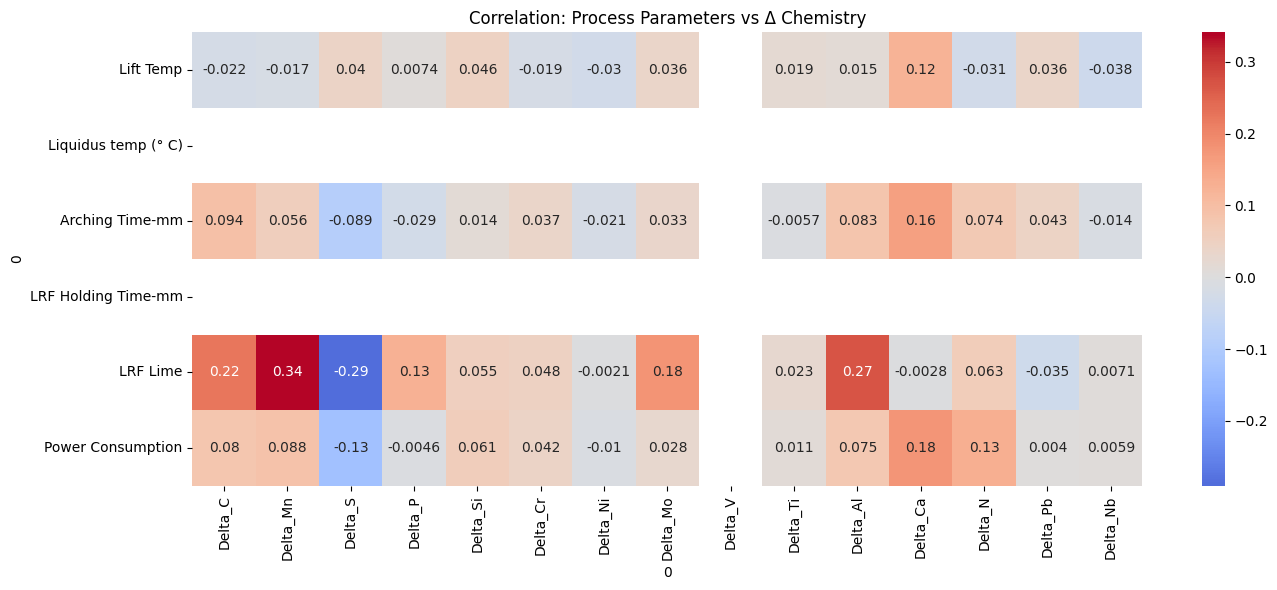

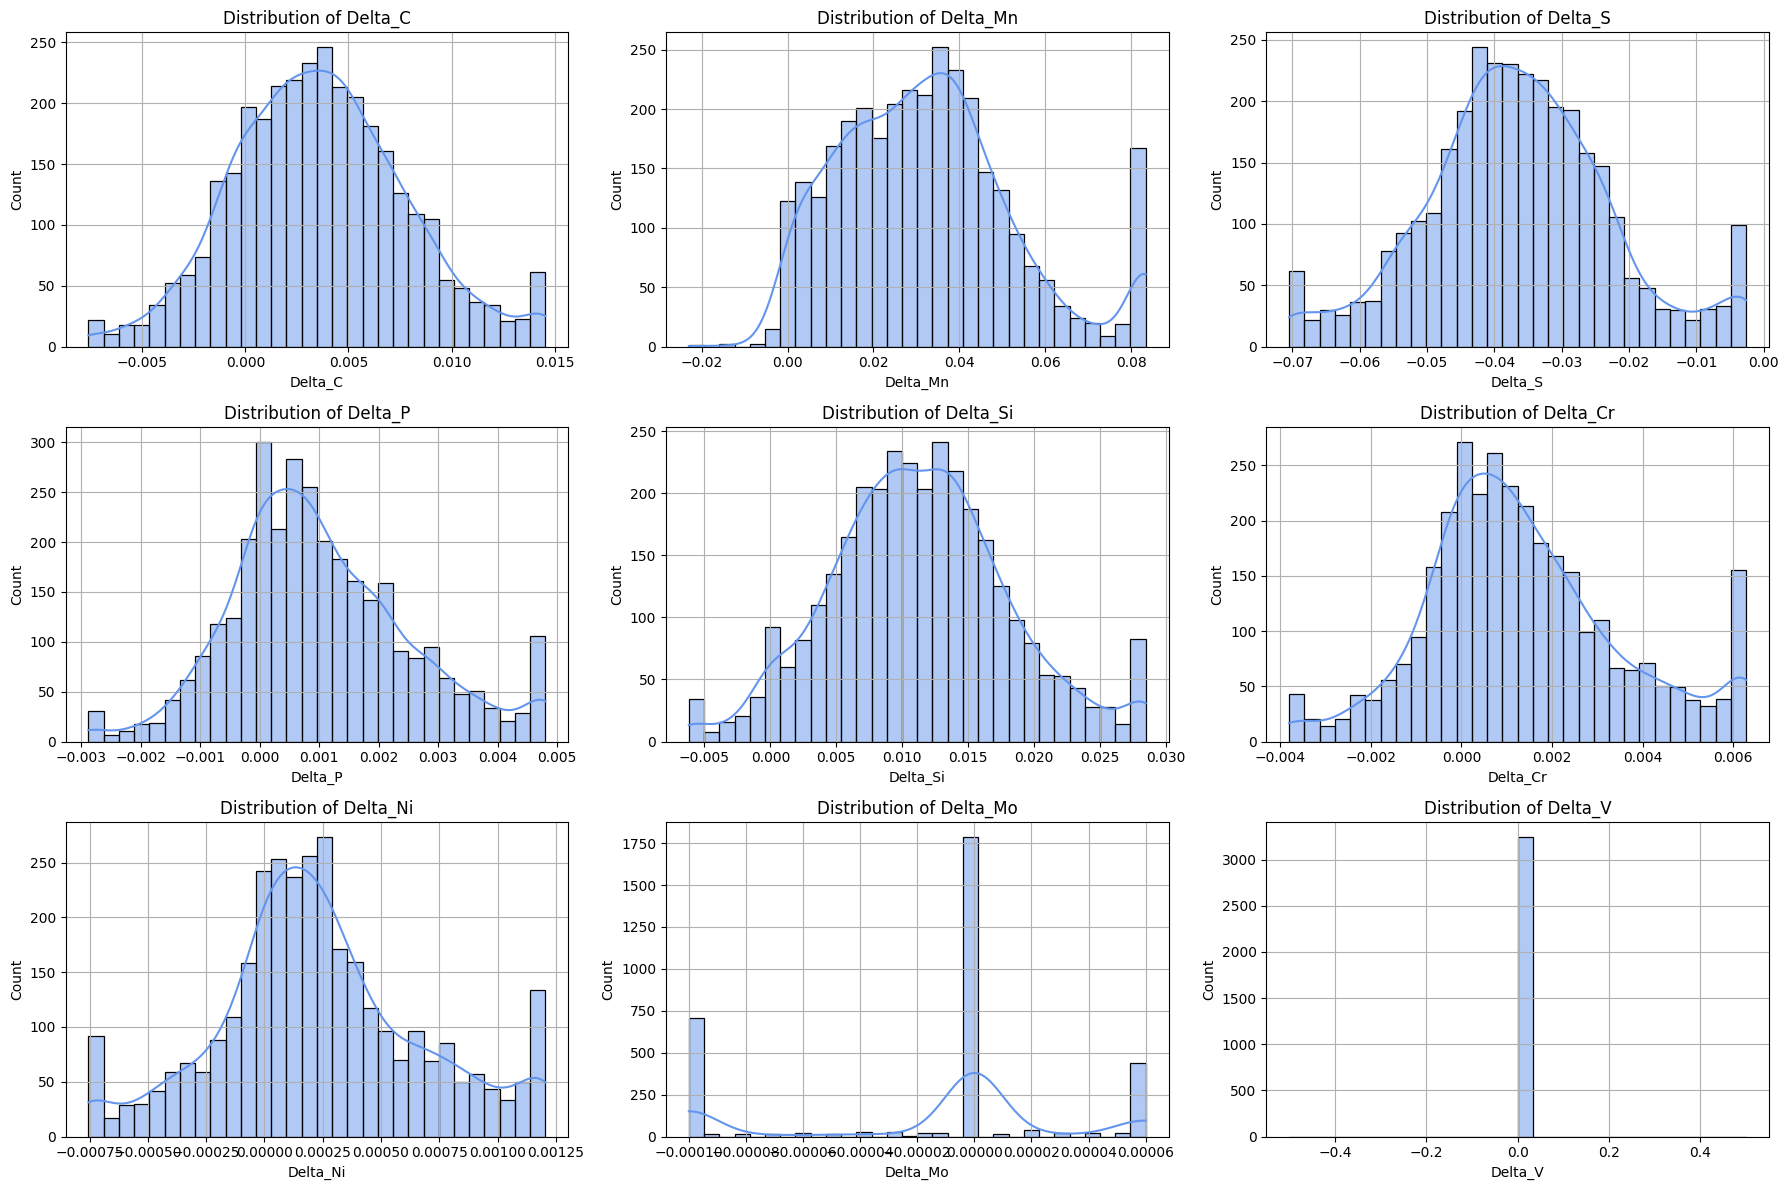

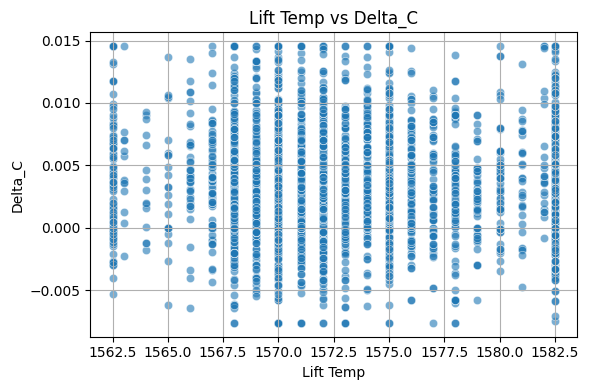

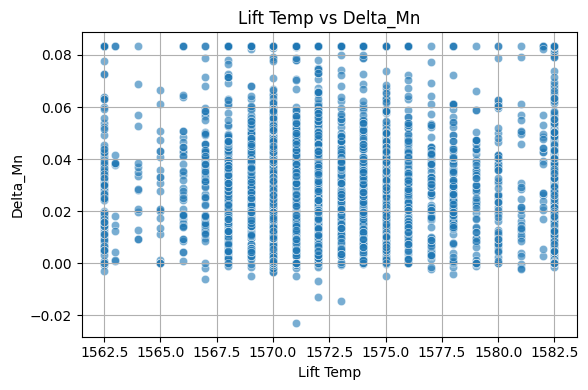

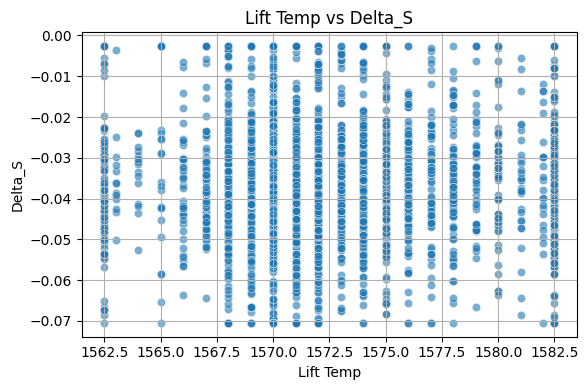

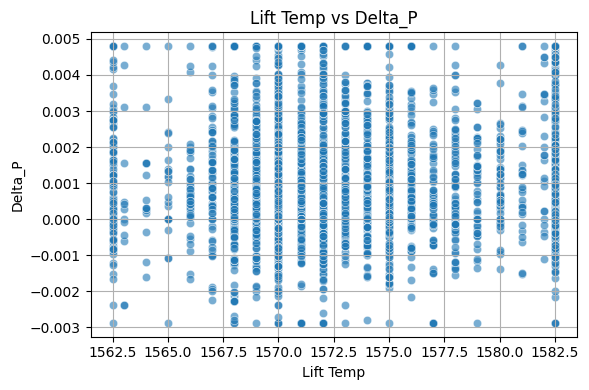

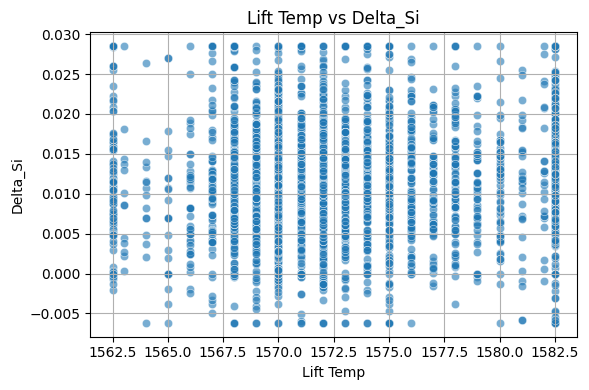

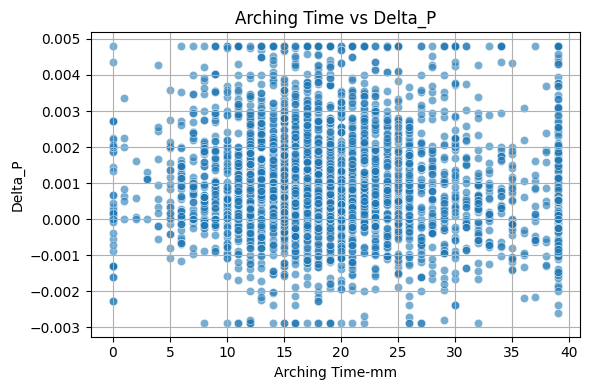

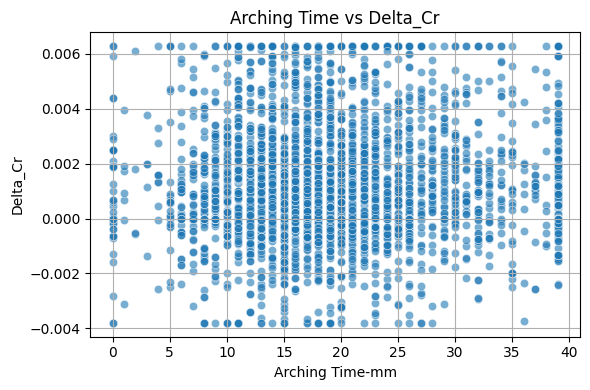

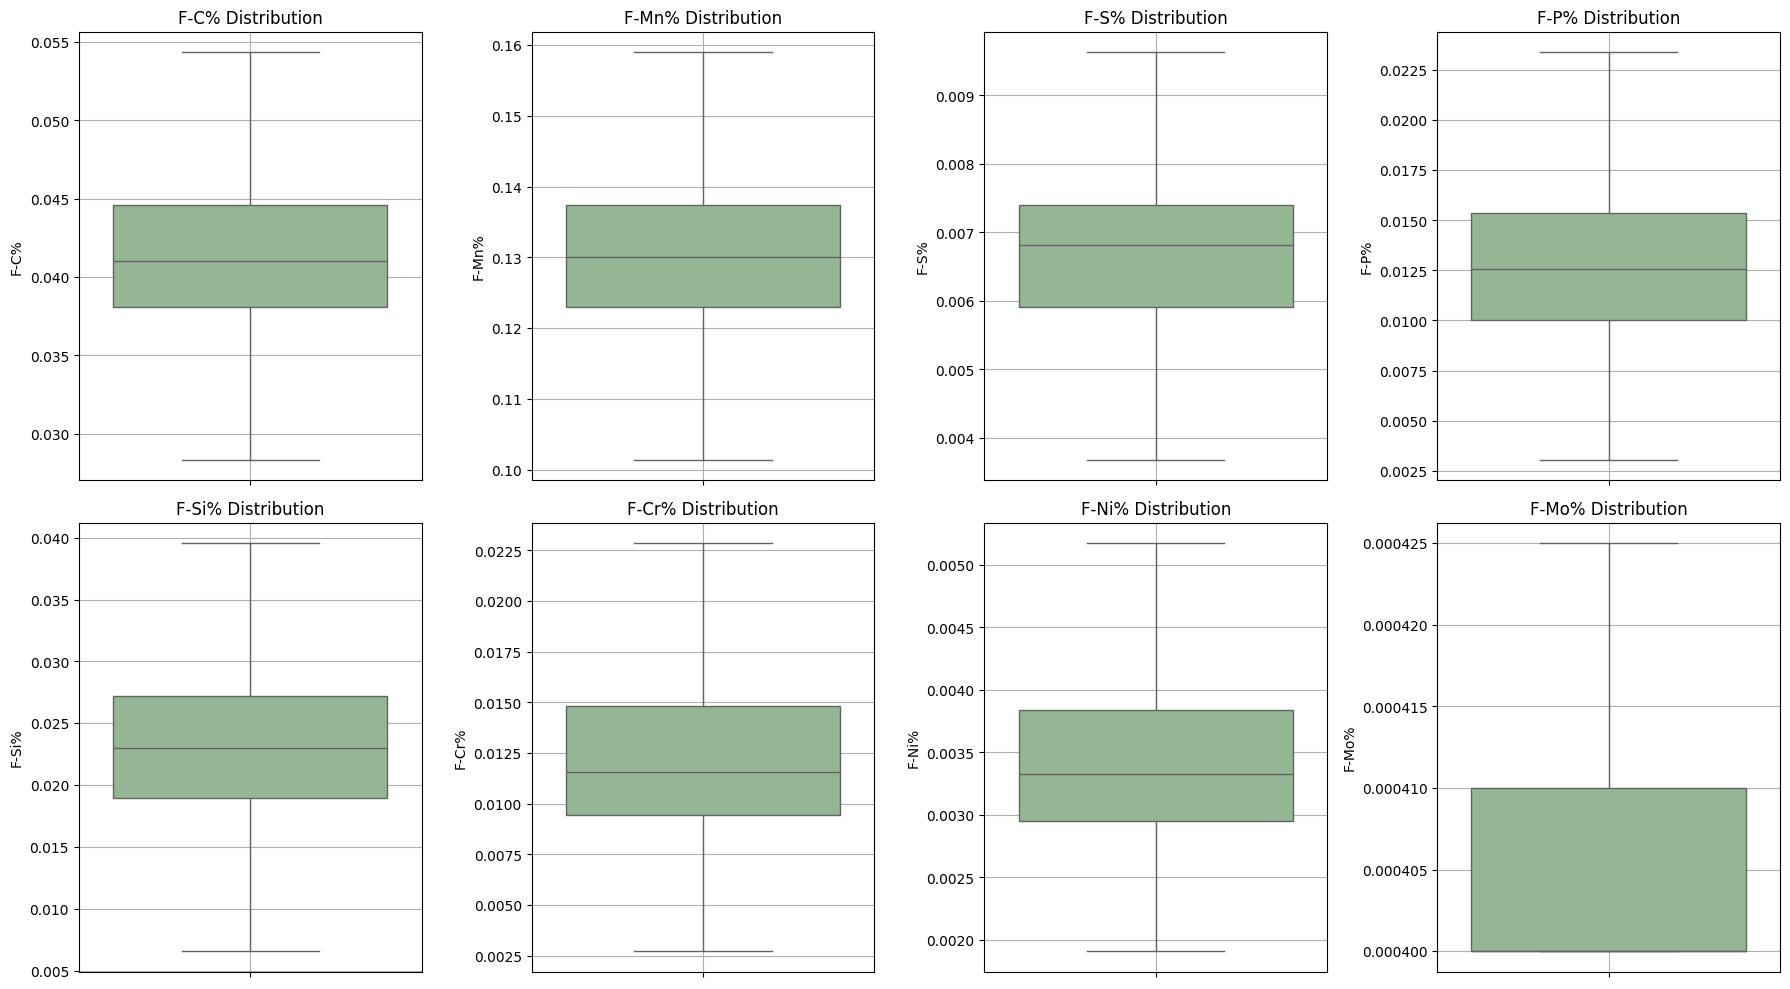

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Assume `df` is preprocessed and loaded
# Identify column groups
delta_chem = [col for col in df.columns if col.startswith("Delta_")]
final_chem = [col for col in df.columns if col.startswith("F-")]
open_chem = [col for col in df.columns if "%" in col and not col.startswith("F-") and not col.startswith("Delta_")]
process_cols = ["Lift Temp", "Liquidus temp (° C)", "Arching Time-mm", "LRF Holding Time-mm", "LRF Lime", "Power Consumption"]

# 1. Correlation Heatmap: Process Parameters vs Δ Chemistry
plt.figure(figsize=(14, 6))
heatmap_df = df[delta_chem + process_cols].corr().loc[process_cols, delta_chem]
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation: Process Parameters vs Δ Chemistry")
plt.tight_layout()
plt.show()

# 2. Distribution Plots for Δ Chemistry
plt.figure(figsize=(18, 12))
for i, col in enumerate(delta_chem[:9], 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='cornflowerblue')
    plt.title(f"Distribution of {col}")
    plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Scatter: Lift Temp vs Δ Chemistry
for delta in delta_chem[:6]:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x="Lift Temp", y=delta, alpha=0.6)
    plt.title(f"Lift Temp vs {delta}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Scatter: Arching Time vs Δ Chemistry
for delta in delta_chem[:6]:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x="Arching Time-mm", y=delta, alpha=0.6)
    plt.title(f"Arching Time vs {delta}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Anomaly Detection using Z-score (e.g., Δ_Mn%)
if "Delta_Mn%" in df.columns:
    df['Z_Δ_Mn'] = zscore(df["Delta_Mn%"])
    sns.histplot(df['Z_Δ_Mn'], bins=50, kde=True)
    plt.axvline(x=2, color='r', linestyle='--')
    plt.axvline(x=-2, color='r', linestyle='--')
    plt.title("Z-score Distribution: Δ_Mn%")
    plt.grid(True)
    plt.show()
    outliers = df[df['Z_Δ_Mn'].abs() > 2]
    print("Detected Anomalous Heats (|Z| > 2):")
    display(outliers[["HEAT_NO", "Delta_Mn%", "Z_Δ_Mn"]].head())

# 6. Final Chemistry Distributions (Boxplot)
plt.figure(figsize=(18, 10))
for i, col in enumerate(final_chem[:8], 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=df[col], orient="v", color='darkseagreen')
    plt.title(f"{col} Distribution")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Load the Summary sheet to extract target values
summary_df = df

# Clean and prepare summary data
summary_df.columns = summary_df.columns.str.strip()
summary_df = summary_df.dropna(how='all')

# Extract chemistry targets from summary for the same grade
# Assume the grade is common or only one
grade_row = summary_df.iloc[0]  # First row for reference

# Get reference values for elements from Summary
target_chem = {}
for el in ['C%', 'Mn%', 'S%', 'P%', 'Si%', 'Cr%', 'Ni%', 'Mo%', 'V%', 'Ti%', 'Al%', 'Ca%', 'N%', 'Pb%', 'Nb%']:
    val = grade_row.get(el)
    if pd.notnull(val) and isinstance(val, (int, float)):
        target_chem[f"F-{el}"] = float(val)

# Calculate Euclidean distance from each heat's final chemistry to target
from sklearn.metrics.pairwise import euclidean_distances

df['HEAT_NO'] = df['HEAT_NO'].astype(str) if 'HEAT_NO' in df.columns else df.index.astype(str)
final_df = df[[col for col in target_chem if col in df.columns]].copy()
target_vector = np.array([target_chem[col] for col in final_df.columns]).reshape(1, -1)
distance = euclidean_distances(final_df.fillna(0), target_vector).flatten()

df['Success_Score'] = -distance  # Higher score is better (closer to target)
top_10_heats = df.sort_values(by="Success_Score", ascending=False).head(10)
# Display top 10 heats with final chemistry and their score (no ace_tools)
top_10_summary = top_10_heats[["HEAT_NO", "Success_Score"] + list(target_chem.keys())].copy()

# Show as formatted table
top_10_summary.reset_index(drop=True, inplace=True)
top_10_summary.head(10)



0 HEAT_NO  Success_Score     F-C%    F-Mn%      F-S%     F-P%    F-Si%  \
0    3193      -0.034552  0.03853  0.10250  0.009635  0.00972  0.01422   
1    2750      -0.034552  0.03853  0.10250  0.009635  0.00972  0.01422   
2    1976      -0.034635  0.03575  0.10135  0.009635  0.01163  0.00692   
3    2038      -0.034636  0.03588  0.10190  0.009635  0.01014  0.01457   
4     718      -0.035376  0.03900  0.10713  0.009500  0.01146  0.01142   
5    2102      -0.035550  0.04529  0.10329  0.009635  0.00799  0.01330   
6     786      -0.036453  0.04447  0.10809  0.009635  0.01345  0.01675   
7    2706      -0.036745  0.03300  0.10135  0.009635  0.01325  0.01692   
8    3149      -0.036745  0.03300  0.10135  0.009635  0.01325  0.01692   
9     612      -0.037004  0.04915  0.10572  0.009635  0.00758  0.01365   

0    F-Cr%    F-Ni%     F-Mo%    F-V%    F-Ti%     F-Al%     F-Ca%      F-N%  \
0  0.00945  0.00330  0.000425  0.0002  0.00079  0.046365  0.000665  0.004925   
1  0.00945  0.00330  0.000425  0.0002  0.00079  0.046365  0.000665  0.004925   
2  0.00853  0.00268  0.000410  0.0002  0.00077  0.046365  0.000665  0.005100   
3  0.00783  0.00236  0.000400  0.0002  0.00084  0.046365  0.000665  0.004925   
4  0.00996  0.00294  0.000400  0.0002  0.00088  0.041000  0.002060  0.005400   
5  0.01000  0.00270  0.000400  0.0002  0.00090  0.045940  0.002200  0.005200   
6  0.00929  0.00319  0.000400  0.0002  0.00083  0.043000  0.002000  0.005200   
7  0.01236  0.00349  0.000400  0.0002  0.00087  0.033300  0.000665  0.004925   
8  0.01236  0.00349  0.000400  0.0002  0.00087  0.033300  0.000665  0.004925   
9  0.01235  0.00403  0.000400  0.0002  0.00090  0.046365  0.000665  0.004925   

0     F-Pb%    F-Nb%  
0  0.000490  0.00031  
1  0.000490  0.00031  
2  0.000400  0.00020  
3  0.000860  0.00020  
4  0.001110  0.00020  
5  0.001275  0.00020  
6  0.000620  0.00032  
7  0.000560  0.00020  
8  0.000560  0.00020  
9  0.000580  0.00028

C:\Users\svasanthavada\AppData\Local\Temp\ipykernel_40940\3413455559.py:36: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\svasanthavada\Documents\Satya\ladle-optimization-ai-1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


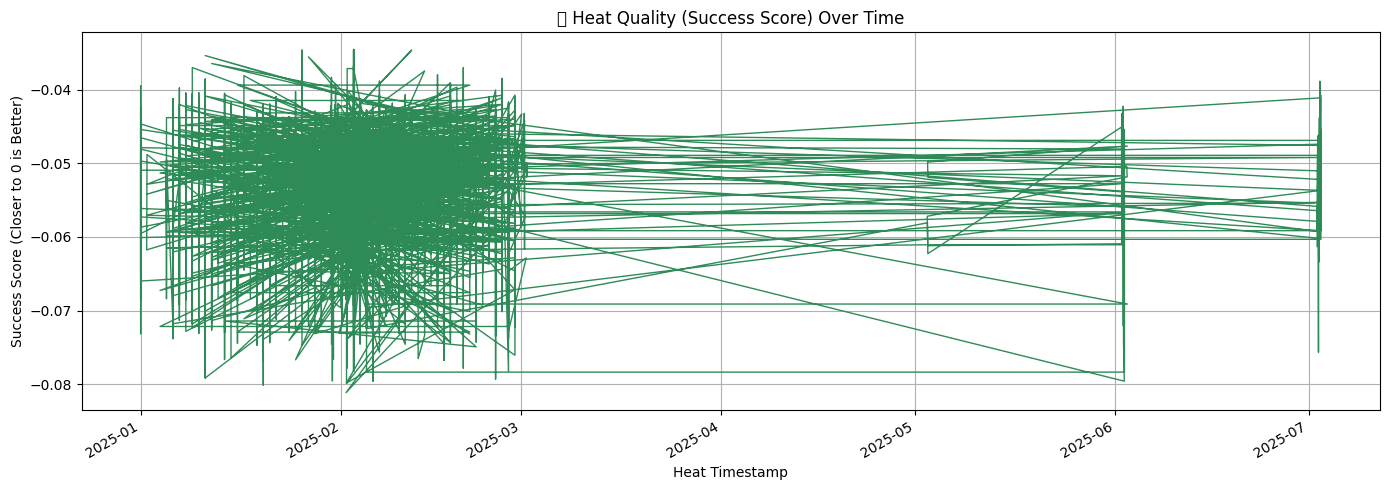

In [21]:
import matplotlib.dates as mdates

# Attempt to extract datetime info from index or timestamp column
date_col = None
for col in df.columns:
    if 'date' in col.lower() or 'timestamp' in col.lower():
        date_col = col
        break

# If no date column, simulate an artificial timeline (1 heat per minute)
if not date_col:
    df['Heat_Timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='min')
    date_col = 'Heat_Timestamp'

# Ensure all timestamps are in datetime format
if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
    try:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)
    except Exception as e:
        # Fallback to artificial time series
        df['Heat_Timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='min')
        date_col = 'Heat_Timestamp'

# Remove rows with invalid timestamps
df = df.dropna(subset=[date_col])

# Plot heat quality over time again
plt.figure(figsize=(14, 5))
plt.plot(df[date_col], df['Success_Score'], color='seagreen', linewidth=1)
plt.title("📈 Heat Quality (Success Score) Over Time")
plt.ylabel("Success Score (Closer to 0 is Better)")
plt.xlabel("Heat Timestamp")
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


C:\Users\svasanthavada\AppData\Local\Temp\ipykernel_40940\2657119244.py:16: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\svasanthavada\Documents\Satya\ladle-optimization-ai-1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


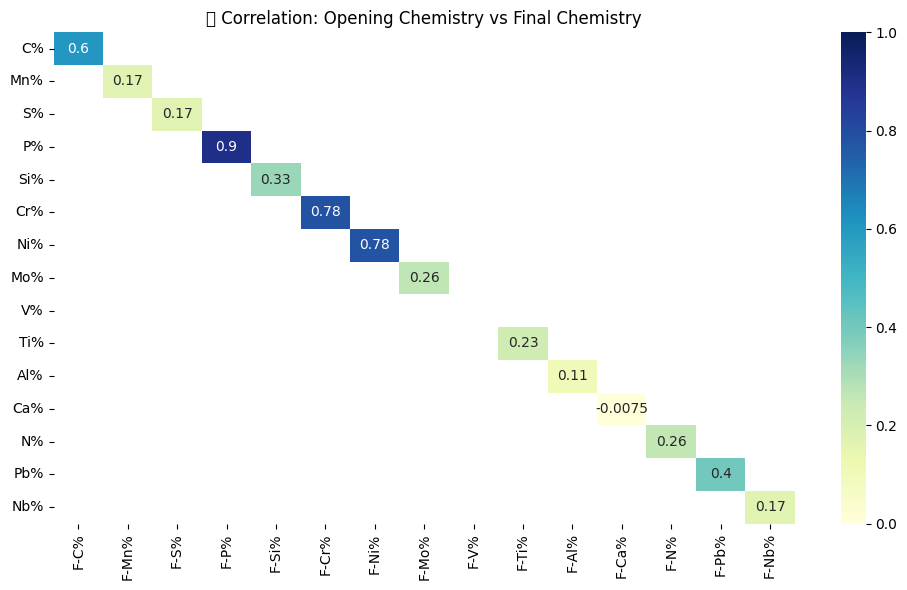

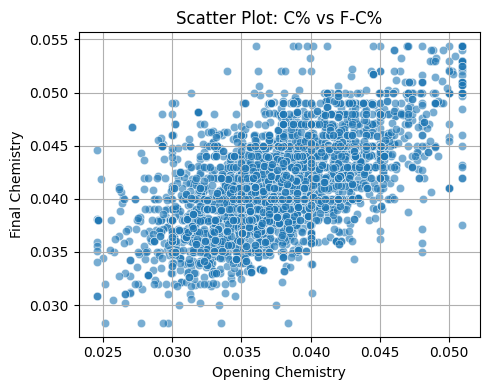

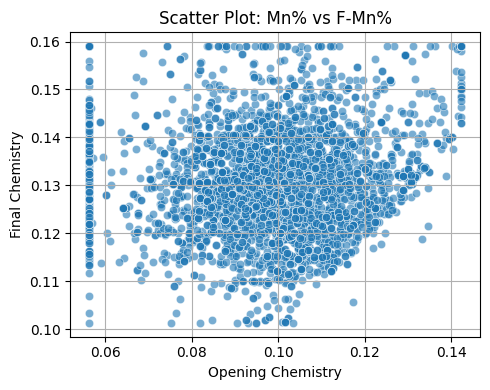

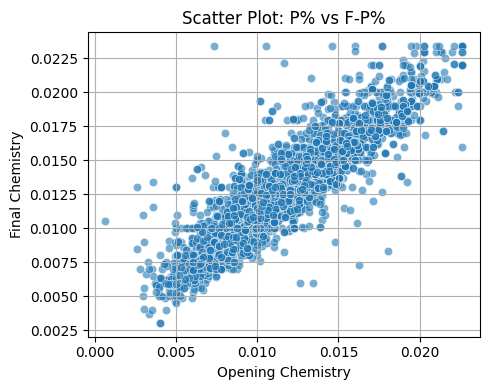

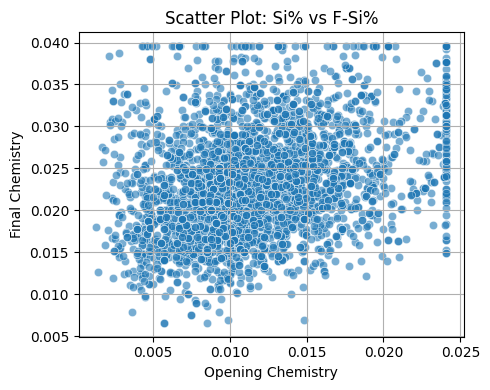

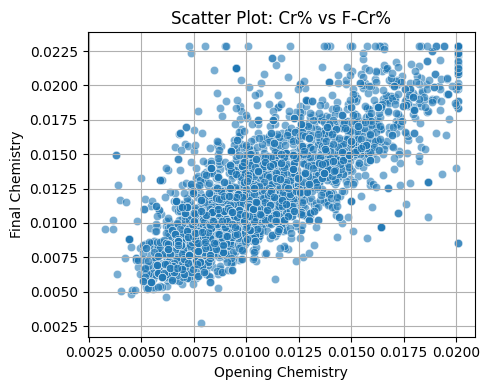

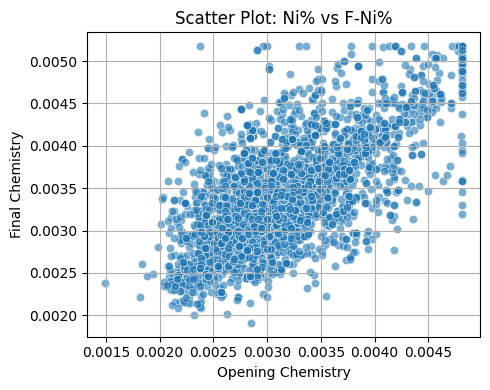

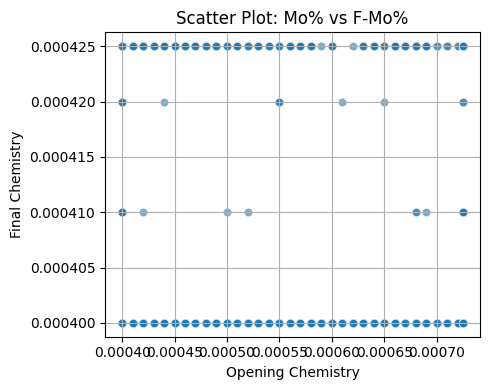

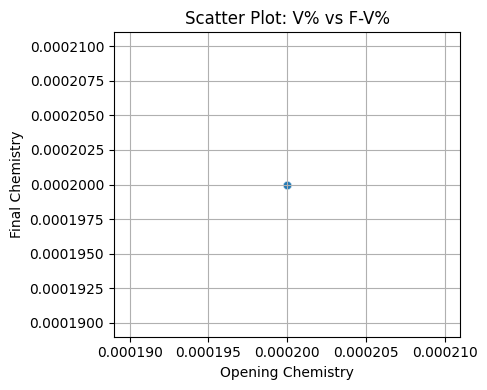

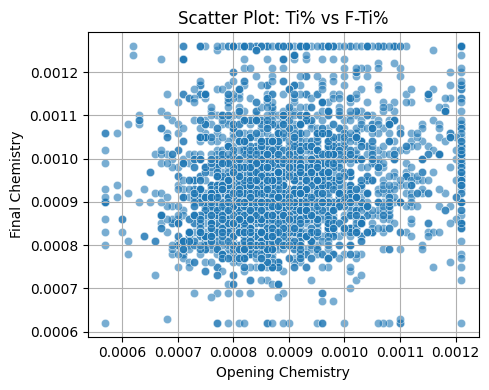

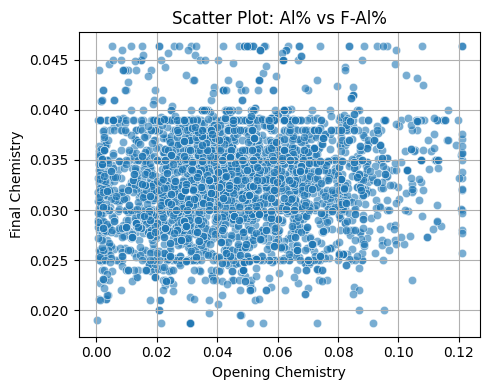

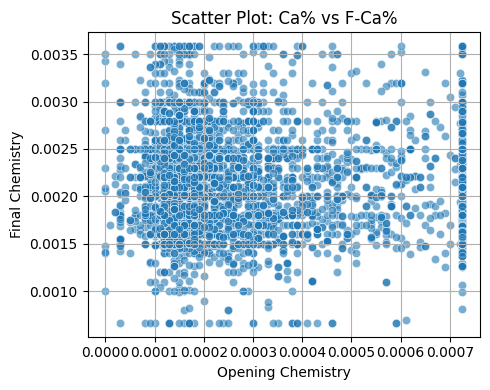

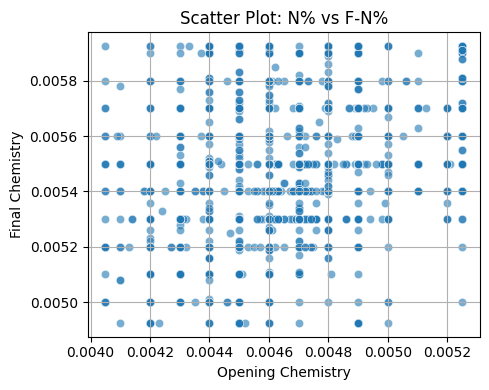

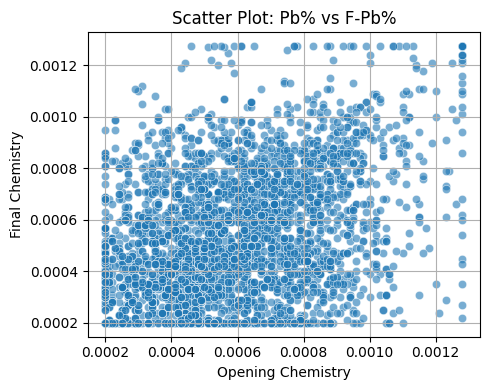

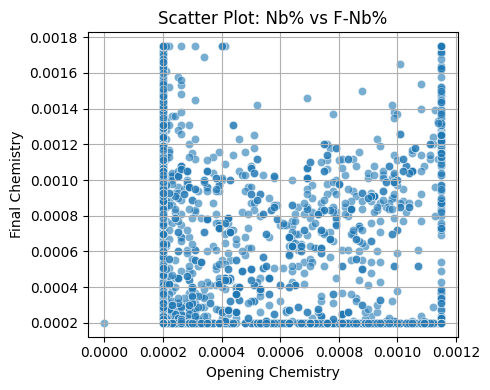

In [22]:
# Correlation matrix between Opening and Final Chemistry
chem_open_final_cols = {col: f"F-{col}" for col in ['C%', 'Mn%', 'S%', 'P%', 'Si%', 'Cr%', 'Ni%', 'Mo%', 'V%', 'Ti%', 'Al%', 'Ca%', 'N%', 'Pb%', 'Nb%']}
common_chem_pairs = {k: v for k, v in chem_open_final_cols.items() if k in df.columns and v in df.columns}

# Build correlation matrix between opening and final chemistry
corr_matrix = pd.DataFrame(index=common_chem_pairs.keys(), columns=common_chem_pairs.values())

for o, f in common_chem_pairs.items():
    corr = df[[o, f]].corr().iloc[0, 1]
    corr_matrix.loc[o, f] = corr

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='YlGnBu', vmin=0.0, vmax=1.0)
plt.title("🔗 Correlation: Opening Chemistry vs Final Chemistry")
plt.tight_layout()
plt.show()


# Plot scatter plots separately for each Opening vs Final Chemistry pair
for o, f in common_chem_pairs.items():
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=o, y=f, alpha=0.6)
    plt.title(f"Scatter Plot: {o} vs {f}")
    plt.xlabel("Opening Chemistry")
    plt.ylabel("Final Chemistry")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\svasanthavada\AppData\Local\Temp\ipykernel_40940\4128967824.py:17: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\svasanthavada\Documents\Satya\ladle-optimization-ai-1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


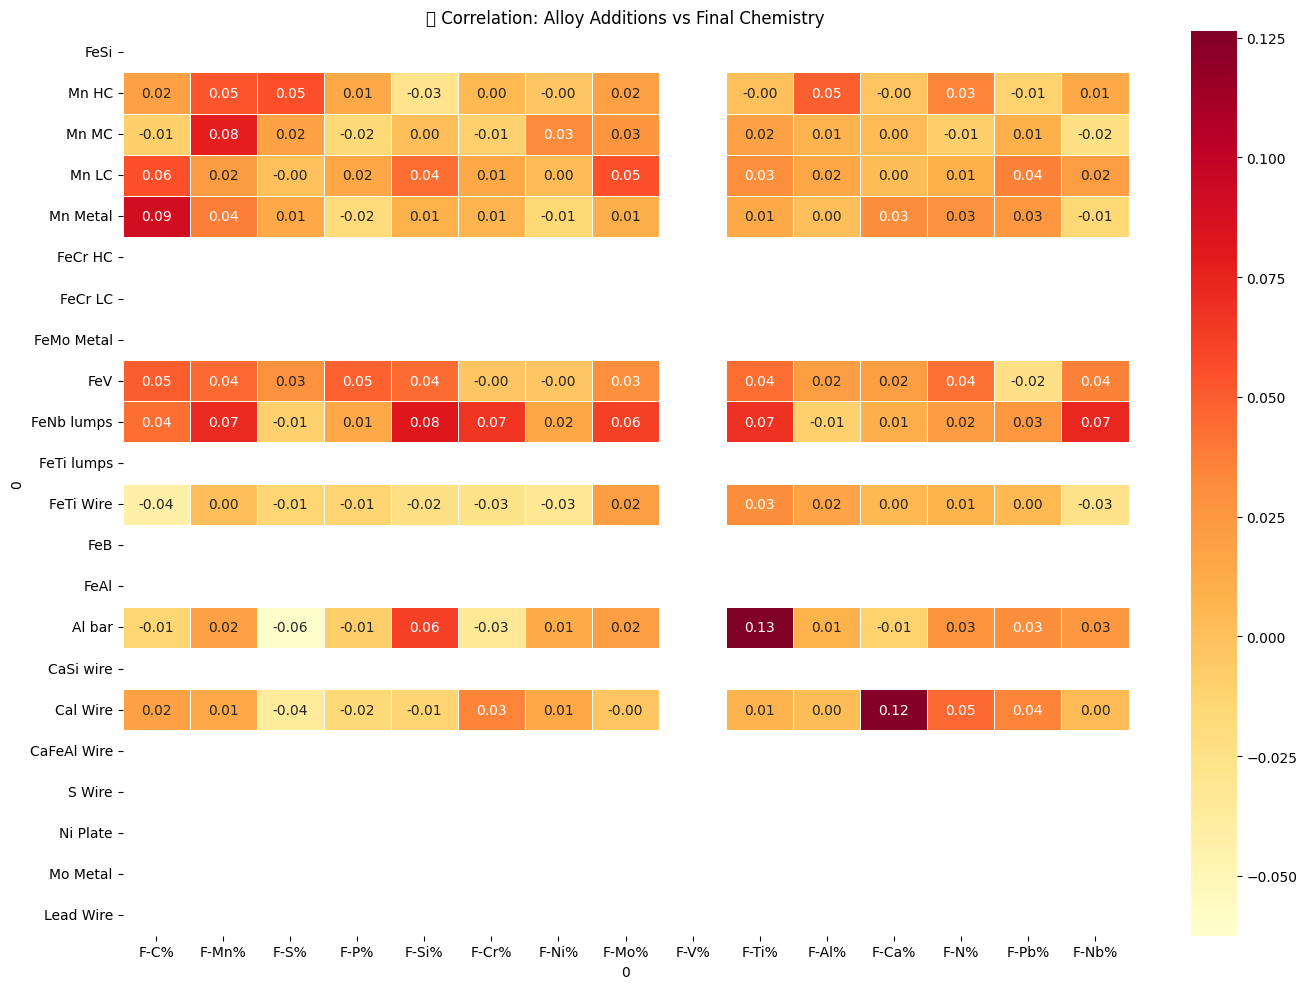

In [23]:
# Identify alloy addition fields vs final chemistry
alloy_additions = ['FeSi', 'Mn HC', 'Mn MC', 'Mn LC', 'Mn Metal', 'FeCr HC', 'FeCr LC', 'FeMo Metal', 'FeV', 'FeNb lumps',
                   'FeTi lumps', 'FeTi Wire', 'FeB', 'FeAl', 'Al bar', 'Al wire', 'CaSi wire', 'Cal Wire',
                   'CaFeAl Wire', 'S Wire', 'Ni Plate', 'Mo Metal', 'Lead Wire']

# Filter available fields from df
alloy_cols = [col for col in alloy_additions if col in df.columns]
final_chem_subset = [col for col in df.columns if col.startswith('F-')]

# Compute correlation matrix: alloy additions vs final chemistry
alloy_final_corr = df[alloy_cols + final_chem_subset].corr().loc[alloy_cols, final_chem_subset]

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(alloy_final_corr, annot=True, cmap='YlOrRd', fmt=".2f", linewidths=0.5)
plt.title("🔧 Correlation: Alloy Additions vs Final Chemistry")
plt.tight_layout()
plt.show()

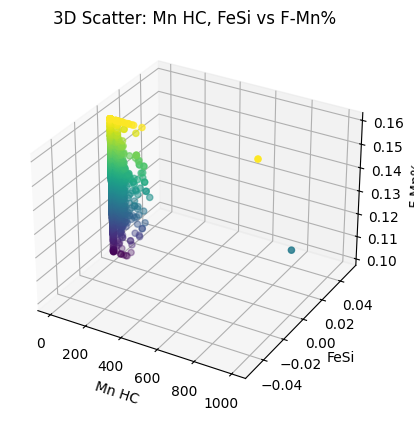

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Select elements for the 3D plot
element1 = 'Mn HC'  # Alloy addition 1
element2 = 'FeSi'   # Alloy addition 2
final_element = 'F-Mn%'  # Final chemistry of interest

# Check if the columns exist in the DataFrame
if element1 in df.columns and element2 in df.columns and final_element in df.columns:
    # Create the 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df[element1], df[element2], df[final_element], c=df[final_element], cmap='viridis')
    ax.set_xlabel(element1)
    ax.set_ylabel(element2)
    ax.set_zlabel(final_element)
    plt.title(f'3D Scatter: {element1}, {element2} vs {final_element}')
    plt.show()
else:
    print(f"Error: One or more columns not found in DataFrame: {element1}, {element2}, {final_element}")
    print(f"Available columns: {df.columns.tolist()}")

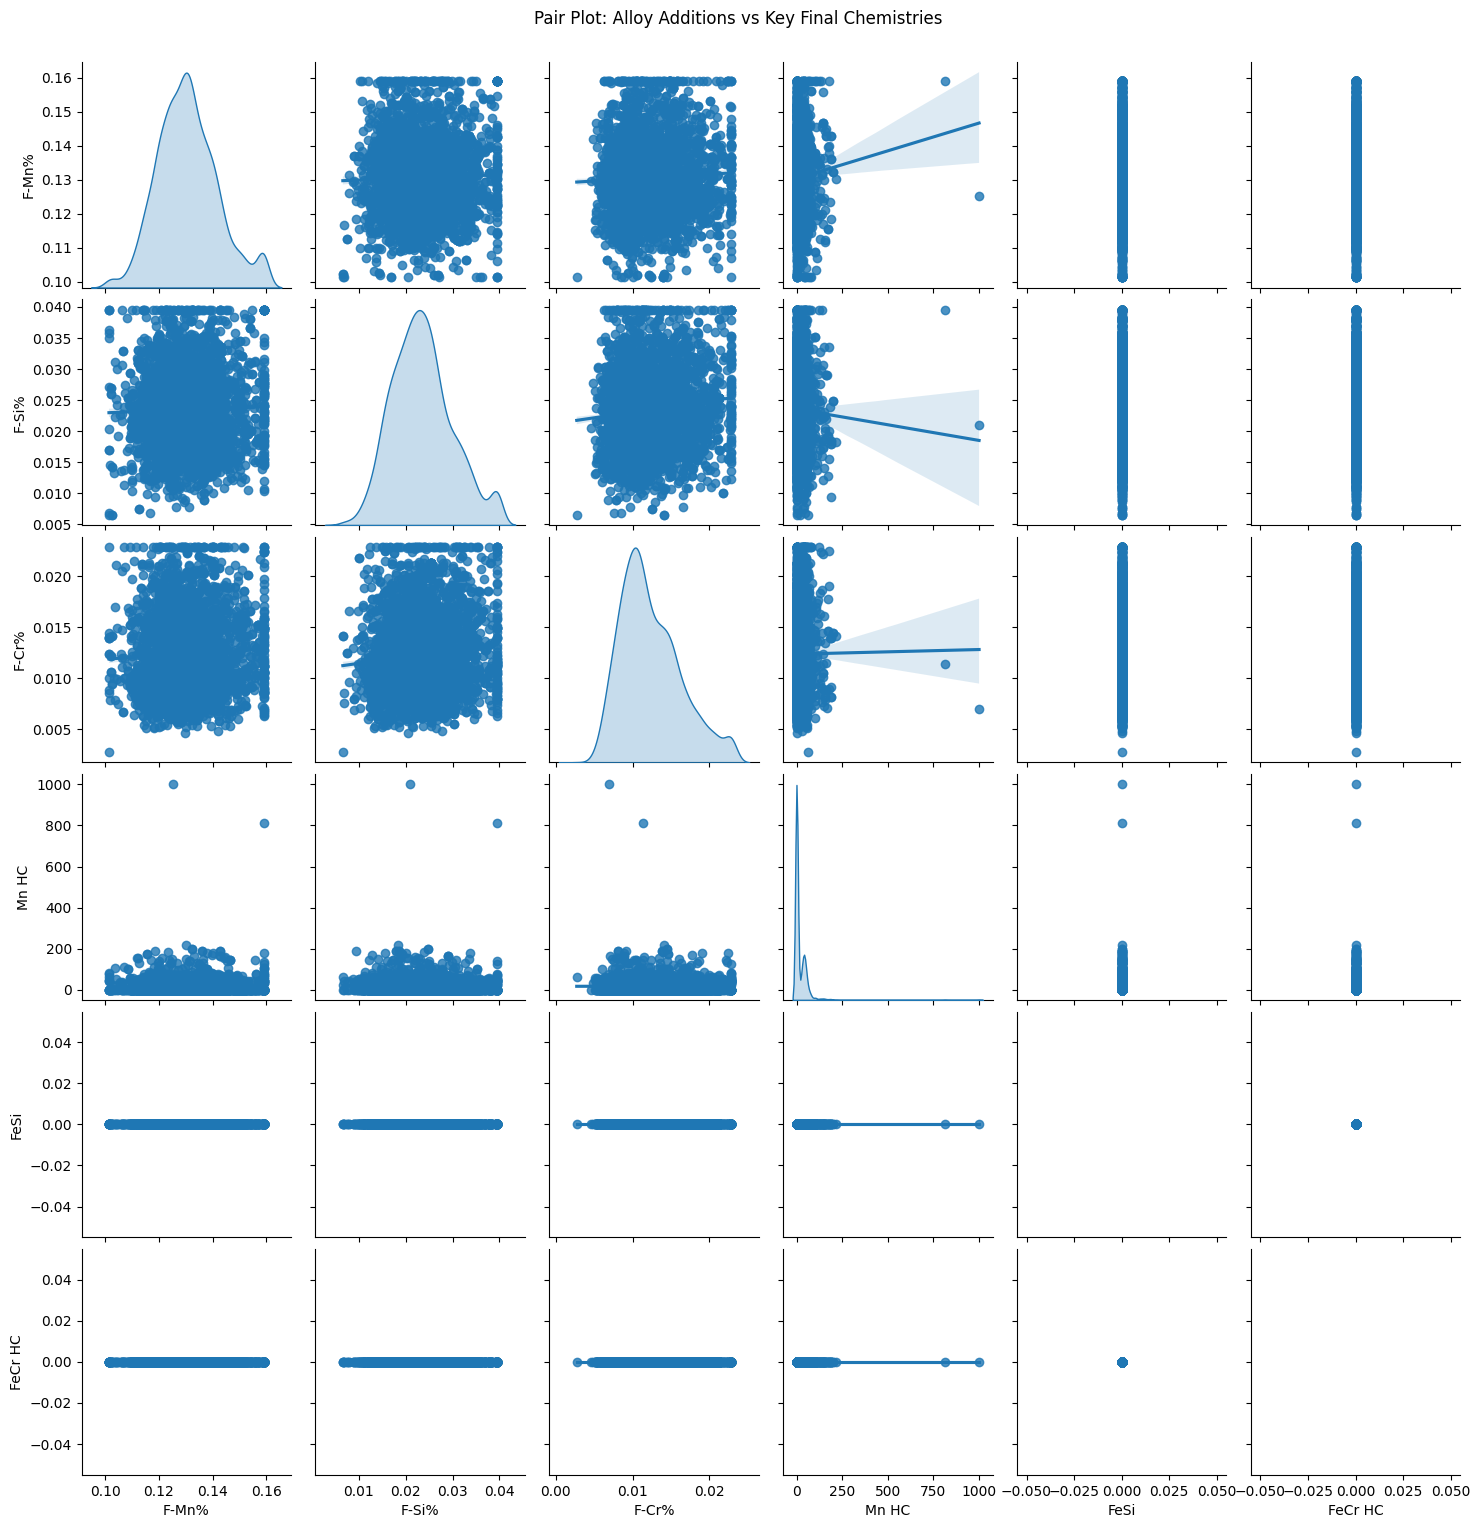

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select key elements for the pair plot
key_elements = ['F-Mn%', 'F-Si%', 'F-Cr%', 'Mn HC', 'FeSi', 'FeCr HC']  # Customize with your elements of interest

# Create the pair plot
sns.pairplot(df[key_elements], kind='reg', diag_kind='kde')
plt.suptitle('Pair Plot: Alloy Additions vs Key Final Chemistries', y=1.02)
plt.show()